In [1]:
!pip install transformers[torch] datasets accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.8 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")

train_ds = emotions["train"]

print(train_ds.features)
print(train_ds[:5])
print(train_ds["text"][:5])

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [3]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

<ipython-input-3-1ca6970f4f6e>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 70223 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [4]:
# hide_output
from datasets import load_dataset

emotions = load_dataset("emotion")

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
len(train_ds)

16000

In [8]:
train_ds.column_names

['text', 'label']

In [9]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [10]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [11]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### **From Datasets to DataFrames**

In [12]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [13]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### **Looking at the Class Distribution**

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one.

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

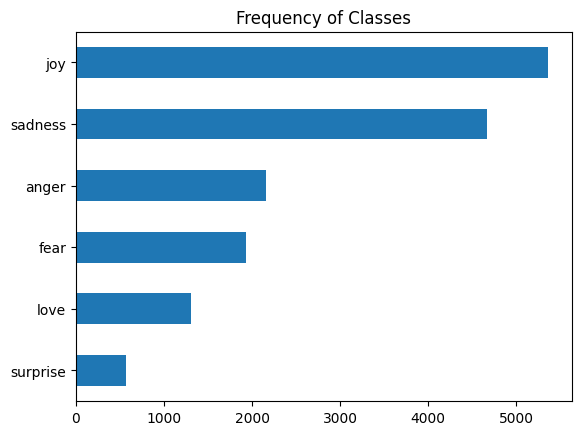

In [14]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas love and surprise are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:

* **Randomly oversample the minority class.**
* **Randomly undersample the majority class.**
* **Gather more labeled data from the underrepresented classes.**

To keep things simple in this chapter, we'll work with the raw, unbalanced class frequencies. If you want to learn more about these sampling techniques, we recommend checking out the Imbalanced-learn library. Just make sure that you don't apply sampling methods before creating your train/test splits, or you'll get plenty of leakage between them!

Now that we've looked at the classes, let's take a look at the tweets themselves.

### **How Long Are Our Tweets?**

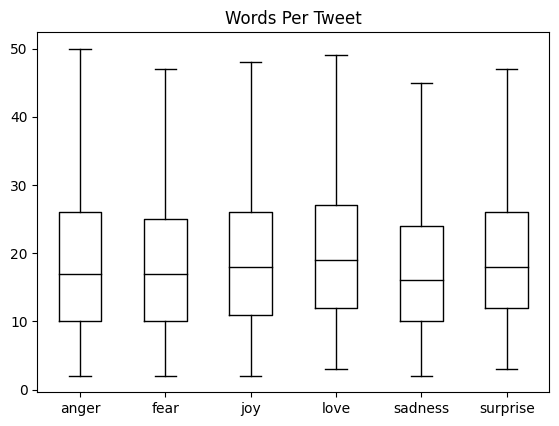

In [15]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [16]:
emotions.reset_format()

### **From Text to Tokens**

In [17]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [19]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [20]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [21]:
 # hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [22]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Fine-Tuning Transformers

In [23]:
from transformers import AutoModelForSequenceClassification
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hide_output
num_labels = 6
id2label = {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
}

label2id = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}

model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [25]:
from huggingface_hub import notebook_login

notebook_login()

In [26]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [27]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.792200,0.288535,0.914000,0.913090
2,0.237600,0.211942,0.930000,0.930030


In [28]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

In [29]:
preds_output.metrics

{'test_loss': 0.2119421362876892,
 'test_accuracy': 0.93,
 'test_f1': 0.9300299042322392,
 'test_runtime': 4.1247,
 'test_samples_per_second': 484.881,
 'test_steps_per_second': 7.758}

In [31]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score

In [32]:
# RoBERTa model
model_name_roberta = "roberta-base"
tokenizer_roberta = RobertaTokenizer.from_pretrained(model_name_roberta)
model_roberta = RobertaForSequenceClassification.from_pretrained(model_name_roberta, num_labels=num_labels)

# Tokenize the data for RoBERTa
emotions_encoded_roberta = emotions.map(tokenize, batched=True, batch_size=None)

# Define training arguments for RoBERTa
training_args_roberta = TrainingArguments(
    output_dir="roberta-finetuned-emotion",
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"
)

# Initialize Trainer for RoBERTa
trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded_roberta["train"],
    eval_dataset=emotions_encoded_roberta["validation"],
    tokenizer=tokenizer_roberta
)

# Train RoBERTa
trainer_roberta.train()

# Evaluate RoBERTa
preds_output_roberta = trainer_roberta.predict(emotions_encoded_roberta["validation"])
metrics_roberta = preds_output_roberta.metrics
print("RoBERTa Metrics:", metrics_roberta)

# Evaluate BERT (assuming 'preds_output' is available)
metrics_bert = preds_output.metrics
print("BERT Metrics:", metrics_bert)



Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.590500,1.567062,0.360000,0.275470
2,1.528100,1.475734,0.419000,0.325836


RoBERTa Metrics: {'test_loss': 1.4757343530654907, 'test_accuracy': 0.419, 'test_f1': 0.3258362348795052, 'test_runtime': 8.3866, 'test_samples_per_second': 238.476, 'test_steps_per_second': 3.816}
BERT Metrics: {'test_loss': 0.2119421362876892, 'test_accuracy': 0.93, 'test_f1': 0.9300299042322392, 'test_runtime': 4.1247, 'test_samples_per_second': 484.881, 'test_steps_per_second': 7.758}
Comparison of Metrics:


KeyError: ignored

In [38]:
# Compare metrics
print("Comparison of Metrics:")
#comparing the test accuracy.
print("Accuracy - BERT:", metrics_bert["test_accuracy"], ", RoBERTa:", metrics_roberta["test_accuracy"])

Comparison of Metrics:
Accuracy - BERT: 0.93 , RoBERTa: 0.419


In [39]:
print("F1 Score - BERT:", metrics_bert.keys(), ", RoBERTa:", metrics_roberta.keys())

F1 Score - BERT: dict_keys(['test_loss', 'test_accuracy', 'test_f1', 'test_runtime', 'test_samples_per_second', 'test_steps_per_second']) , RoBERTa: dict_keys(['test_loss', 'test_accuracy', 'test_f1', 'test_runtime', 'test_samples_per_second', 'test_steps_per_second'])
